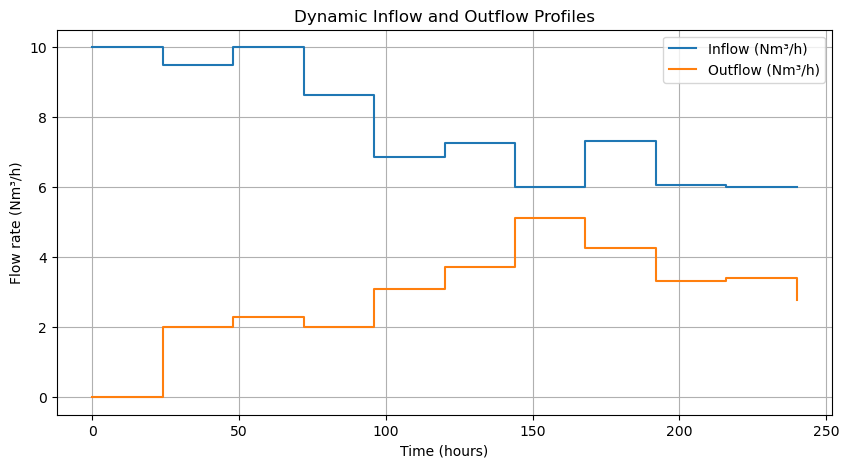

Simulation complete. Result preview:
                   e0_n          e0_p  e0_F_d_in  e0_inflow  e0_outflow
1970-01-01     0.000000  2.349745e-12   0.123931   0.123931    0.000153
1970-01-02  2298.341517  1.120326e+06   0.068393   0.068393    0.061965
1970-01-03  2531.391104  1.233926e+06   0.062762   0.062762    0.061965
1970-01-04  2560.280783  1.248008e+06   0.062064   0.062064    0.061965
1970-01-05  2563.860943  1.249754e+06   0.061977   0.061977    0.061965


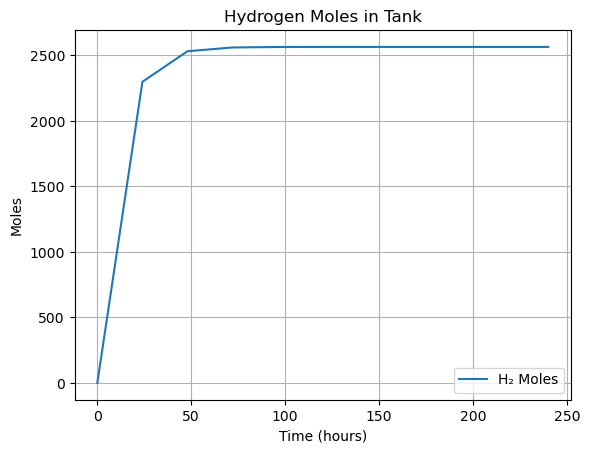

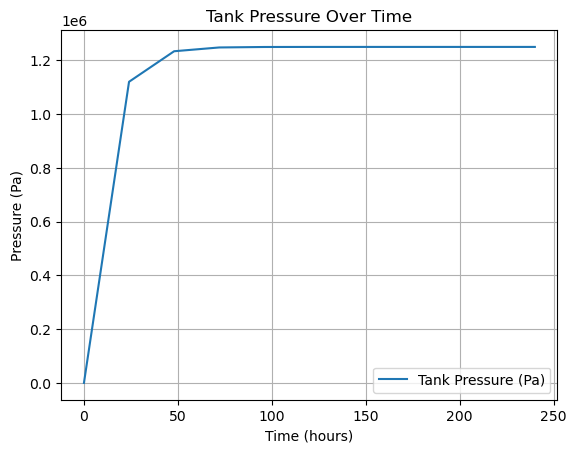

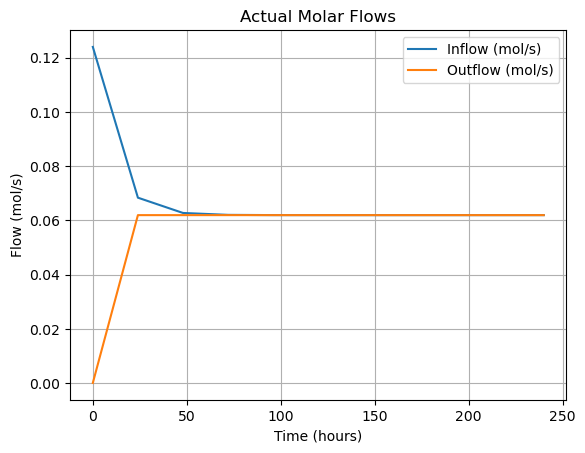

In [ ]:
import casadi as ca
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mopeds


def initialize_problem():
    variable_list = mopeds.VariableList()

    # Define variables
    variable_list.add_variable(mopeds.VariableState("e0_n", 0.0))  # moles of H2
    variable_list.add_variable(mopeds.VariableAlgebraic("e0_p", 0.0))  # tank pressure
    variable_list.add_variable(mopeds.VariableAlgebraic("e0_F_d_in", 0.0))  # net inflow
    variable_list.add_variable(mopeds.VariableAlgebraic("e0_inflow", 0.0))
    variable_list.add_variable(mopeds.VariableAlgebraic("e0_outflow", 0.0))

    variable_list.add_variable(mopeds.VariableControl("e0_F_in_raw", 10.0))   # Nm³/h
    variable_list.add_variable(mopeds.VariableControl("e0_F_out_raw", 5.0))   # Nm³/h
    variable_list.add_variable(mopeds.VariableControl("e0_p_max", 2.5e6))     # 25 bar
    variable_list.add_variable(mopeds.VariableControl("e0_R", 8.314))         # J/mol·K
    variable_list.add_variable(mopeds.VariableControl("e0_T", 293.15))        # K
    variable_list.add_variable(mopeds.VariableControl("e0_V", 5.0))           # m³

    # Create model
    m = mopeds.Model(variable_list)

    # CasADi variables
    e0_n = m.varlist_all["e0_n"].casadi_var
    e0_p = m.varlist_all["e0_p"].casadi_var
    e0_F_d_in = m.varlist_all["e0_F_d_in"].casadi_var
    e0_F_in_raw = m.varlist_all["e0_F_in_raw"].casadi_var
    e0_F_out_raw = m.varlist_all["e0_F_out_raw"].casadi_var
    e0_p_max = m.varlist_all["e0_p_max"].casadi_var
    e0_R = m.varlist_all["e0_R"].casadi_var
    e0_T = m.varlist_all["e0_T"].casadi_var
    e0_V = m.varlist_all["e0_V"].casadi_var

    # Conversion factor (Nm³/h to mol/s)
    nm3ph_to_molps = 44.615 / 3600

    # Inflow logic (pressure-dependent shutoff)
    inflow_raw = ca.if_else(e0_p < e0_p_max, e0_F_in_raw * (1 - e0_p / e0_p_max), 0.0)  #inflow calculation

    # Outflow logic (smooth activation over pressure threshold)
    p_threshold = 3e5  # 3 bar
    transition_width = 1e5  # ~1 bar smoothing
    outflow_factor = 0.5 * (1 + ca.tanh((e0_p - p_threshold) / transition_width))    #outflow calculation
    outflow_raw = outflow_factor * e0_F_out_raw

    # Convert flows to mol/s
    inflow = inflow_raw * nm3ph_to_molps
    outflow = outflow_raw * nm3ph_to_molps

    # Differential and algebraic equations
    EQ_diff = inflow - outflow
    EQ_alg1 = e0_F_d_in - inflow
    EQ_alg2 = e0_p - (e0_n * e0_R * e0_T / e0_V)
    EQ_alg3 = m.varlist_all["e0_inflow"].casadi_var - inflow
    EQ_alg4 = m.varlist_all["e0_outflow"].casadi_var - outflow

    m.add_equations_differential([EQ_diff])
    m.add_equations_algebraic([EQ_alg1, EQ_alg2, EQ_alg3, EQ_alg4])

    # Initial conditions
    m.varlist_all["e0_n"].dataframe = pd.DataFrame([{"time": 0.0, "e0_n": 0.0}])
    m.varlist_all["e0_p"].dataframe = pd.DataFrame([{"time": 0.0, "e0_p": 0.0}])
    m.varlist_all["e0_F_d_in"].dataframe = pd.DataFrame([{"time": 0.0, "e0_F_d_in": 0.0}])
    m.varlist_all["e0_inflow"].dataframe = pd.DataFrame([{"time": 0.0, "e0_inflow": 0.0}])
    m.varlist_all["e0_outflow"].dataframe = pd.DataFrame([{"time": 0.0, "e0_outflow": 0.0}])

    return variable_list, m


if __name__ == "__main__":
    np.random.seed(42)

    total_time = 10 * 24 * 3600  # Simulate 10 days (in seconds)
    n_changes = 10  # About 10 flow level changes

    # === Generate Step Change Times ===
    change_times = np.linspace(0, total_time, n_changes + 1)

    # === Generate Dynamic Flow Profiles ===
    F_in_vals = [10.0]  # Start high inflow
    F_out_vals = [0.0]  # Start with zero outflow

    for i in range(1, len(change_times)):
        # Gradually adjust inflow (range 6-10 Nm³/h)
        next_in = np.clip(F_in_vals[-1] + np.random.uniform(-2.0, 2.0), 6.0, 10.0)
        F_in_vals.append(next_in)

        # Gradually adjust outflow (range 2-6 Nm³/h)
        next_out = np.clip(F_out_vals[-1] + np.random.uniform(-1.5, 1.5), 2.0, 6.0)
        F_out_vals.append(next_out)

    # === Plot Flow Profiles ===
    plt.figure(figsize=(10, 5))
    plt.step(change_times / 3600, F_in_vals, where='post', label='Inflow (Nm³/h)')
    plt.step(change_times / 3600, F_out_vals, where='post', label='Outflow (Nm³/h)')
    plt.xlabel("Time (hours)")
    plt.ylabel("Flow rate (Nm³/h)")
    plt.title("Dynamic Inflow and Outflow Profiles")
    plt.legend()
    plt.grid()
    plt.show()

    # === Initialize Model ===
    var_list, m = initialize_problem()

    # === Apply Flow Profiles to Model ===
    df_in = pd.DataFrame([{"time": t, "e0_F_in_raw": F_in_vals[i]} for i, t in enumerate(change_times)])
    df_out = pd.DataFrame([{"time": t, "e0_F_out_raw": F_out_vals[i]} for i, t in enumerate(change_times)])
    m.varlist_all["e0_F_in_raw"].dataframe = df_in
    m.varlist_all["e0_F_out_raw"].dataframe = df_out

    # === Run Simulation ===
    sim = mopeds.Simulator(m, change_times, var_list)
    result = sim.generate_exp_data(algebraic=True, recalculate_algebraic=True)

    print("Simulation complete. Result preview:")
    print(result.dataframe.head())

    # === Process and Plot Results ===
    df_result = result.dataframe.copy()
    df_result["time_h"] = (df_result.index - df_result.index[0]).total_seconds() / 3600

    # Moles
    plt.figure()
    plt.plot(df_result["time_h"], df_result["e0_n"], label="H₂ Moles")
    plt.xlabel("Time (hours)")
    plt.ylabel("Moles")
    plt.title("Hydrogen Moles in Tank")
    plt.grid()
    plt.legend()
    plt.show()

    # Tank Pressure
    plt.figure()
    plt.plot(df_result["time_h"], df_result["e0_p"], label="Tank Pressure (Pa)")
    plt.xlabel("Time (hours)")
    plt.ylabel("Pressure (Pa)")
    plt.title("Tank Pressure Over Time")
    plt.grid()
    plt.legend()
    plt.show()

    # Actual Molar Flows
    plt.figure()
    plt.plot(df_result["time_h"], df_result["e0_inflow"], label="Inflow (mol/s)")
    plt.plot(df_result["time_h"], df_result["e0_outflow"], label="Outflow (mol/s)")
    plt.xlabel("Time (hours)")
    plt.ylabel("Flow (mol/s)")
    plt.title("Actual Molar Flows")
    plt.grid()
    plt.legend()
    plt.show()

    # === Save Results ===
    result.dataframe.to_csv("sim_fill_from_zero_pressure.csv")
